### Python libraries 
Please activate the Conda environment you created in the terminal command line, and then execute the following commands **line by line** (the first command changes the default pip source to the Tsinghua mirror, which is recommended):
```
conda create -n class5_env python=3.8
conda activate class5_env
pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
pip install notebook
pip install numpy
pip install matplotlib
pip install ipykernel
pip install pandas
pip install biopython~=1.79
pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 -f https://mirrors.aliyun.com/pytorch-wheels/cu118
```

## AI-assisted Enzyme Design
### Design enzymes using language models and evaluate 

## The exercise today is mainly about how to train a language model for enzyme designing and use multiple models for enzyme evaluation, which includes:

1. Designing enzymes using [ProGen](https://www.nature.com/articles/s41587-022-01618-2)
2. Convert the ADH natural sequence dataset fasta file to a tsv file
3. Designing enzymes using [ESM-MSA](https://github.com/facebookresearch/esm)
4. Enzyme structure prediction
5. Evaluation of enzyme sequence and structure using multiple models

## 1. Designing enzymes using progen

### 1.1 Introduction to progen

- **Introduction**: Progen is a language model for protein engineering developed by Salesforce.It can generate protein sequences with a predictable function across large protein families, akin to generating grammatically and semantically correct natural language sentences on diverse topics. The model was trained on 280 million protein sequences from >19,000 families and is augmented with control tags specifying protein properties.Its purpose is to help researchers and developers use deep learning models to design, optimize, and generate proteins with specific functions or structures.
- **Progen Key Features**:
  - **Technical foundation**: Transformer-based conditional language model
  - **Protein generating**: ProGen is iteratively optimized by learning to predict the probability of the next amino acid given the past amino acids in a raw sequence, with no explicit structural information or pairwise coevolutionary assumptions.Trained in this unsupervised manner from a large, varied protein sequence database, ProGen learns a universal, domain-independent representation of proteins that subsumes local and global structure motifs, analogous to natural language models learning semantic and grammatical rules. After training, ProGen can be prompted to generate full-length protein sequences for any protein family from scratch, with a varying degree of similarity to natural proteins. 
  - **Functional design**: Using Progen, users can design target proteins to have specific functions, such as binding to other molecules or catalyzing certain chemical reactions.These protein sequences can be further used in experiments as the basis for drug design, vaccine development, etc.

### 1.2 Setup
To use progen, please execute the following commands first **line by line**:  
(**Attention!!**:Please change the path of requirement.txt to your absolute path)
```
pip3 install --upgrade pip setuptools
pip3 install -r /path/to/your/folder/requirements.txt
```


### 1.3 Fine-tuning

**Fine-tuning** usually refers to further adjusting and optimizing an already trained model to make it perform better on a specific task or dataset.

Specifically, fine-tuning is based on a pre-trained model that has been trained extensively (such as GPT, BERT, ResNet, etc.), and then adapting the model to new task requirements by continuing to train the model on a relatively small dataset related to the target task. This method saves a lot of time and computing resources compared to training the model from scratch.
- **General fine-tuning process**:
  - **Choose a pre-trained model**: Choose a pre-trained protein language model. For example, DeepMind's AlphaFold model, ProtBERT, ESM (such as Facebook's ESM-1b), etc., are deep learning models trained on protein sequences and are suitable for fine-tuning.
  - **Prepare a dataset**: Prepare a dataset for your target task. For example, tasks such as protein classification, protein structure prediction, and functional annotation.The dataset is usually the sequence information of the protein (such as FASTA format), or contains annotated functional information, structural data, etc.
  - **Adjust model input**: Protein language models usually receive protein sequences as input. You need to convert the input sequence into a format that the model can accept. If using a model like ProtBERT, the input is usually a sequence of tokens (amino acid codes).
  - **Set task-specific output layers**: Depending on your task, you may need to modify the output layer of the model. For example, when doing protein classification tasks, the output layer should be a classification layer; if it is a sequence annotation task, the output may be a label for each position.
  - **Fine-tune training**: Fine-tune the pre-trained model on the target task dataset. At this point, you might use a common deep learning framework, such as PyTorch or TensorFlow, to load the model and train it. Adjusting hyperparameters such as learning rate and batch size usually requires some experiments to find the best settings.
  - **Evaluation and tuning**: Evaluate the performance of the model on the validation set and adjust the model parameters as needed to avoid overfitting or underfitting.

#### Imports Essential Libraries And Modules

In [1]:
import random
from tokenizers import Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm, trange
from models.progen.modeling_progen import ProGenForCausalLM
import matplotlib.pyplot as plt

/data/home/jiawei/anaconda3/envs/class5_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cluster File Reader for FASTA Sequences

We have clustered the fasta files at 80% similarity using all ADH sequences from Drosophila and saved the results in 'adh_0.8_clu_all_seqs.fasta'. This function parses a FASTA file and organizes sequences into clusters based on headers.

In [2]:
def read_cluster_file(file_path):
    # Initialize an empty dictionary to store clusters
    clusters = {}
    # Variable to keep track of the current cluster name
    current_cluster = None
    # List to store sequences belonging to the current cluster
    sequences = []
    
    # Open the file and read all lines
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        # Loop through each line in the file
        for i in range(len(lines)):
            line = lines[i].strip()  # Remove leading/trailing whitespaces
            
            # Skip empty lines
            if not line:
                continue

            # Check if the line starts with '>', which indicates a cluster name
            if line.startswith('>'):
                # If the next line also starts with '>', it's a cluster name, not a sequence description
                if i + 1 < len(lines) and lines[i + 1].startswith('>'):
                    if current_cluster is not None:
                        # If there's already a cluster, save the current cluster's sequences
                        clusters[current_cluster] = sequences
                    
                    # Extract the cluster name by removing the '>' and strip extra spaces
                    current_cluster = line[1:].strip()
                    # Reset the sequence list for the new cluster
                    sequences = []
                else:
                    # If it's just a sequence description line (not a cluster name), skip it
                    continue

            # If the line is not a cluster name (does not start with '>'), it's a sequence content line
            elif current_cluster is not None:
                # Add the sequence line to the current cluster's sequence list
                sequences.append(line)

        # After the loop, save the last cluster's data if any
        if current_cluster is not None:
            clusters[current_cluster] = sequences
    
    # Return the dictionary containing all clusters and their corresponding sequences
    return clusters

# Testing the function
cluster_file = 'adh_0.8_clu_all_seqs.fasta' 
clusters = read_cluster_file(cluster_file)

# Print debug information to check the dictionary contents
print(f"Number of clusters: {len(clusters)}")
for cluster, seqs in clusters.items():
    print(f"Cluster {cluster} contains {len(seqs)} sequences")

print(f"\nDetails of Sequences in Cluster A0AAU6PWN6:")
print(clusters["A0AAU6PWN6"])  # Print sequences in a specific cluster

# This function returns a dictionary where the keys are cluster names and the values are lists of sequences 
# belonging to that cluster (excluding description lines).

Number of clusters: 1683
Cluster P00334 contains 221 sequences
Cluster Q0KDL6 contains 34 sequences
Cluster Q64437 contains 1 sequences
Cluster Q6WVP7 contains 1 sequences
Cluster Q8GAK7 contains 1 sequences
Cluster Q8GIX7 contains 2 sequences
Cluster Q97YM2 contains 1 sequences
Cluster A0A0A9XJ13 contains 1 sequences
Cluster P00332 contains 1 sequences
Cluster P0CH37 contains 3 sequences
Cluster Q1G151 contains 1 sequences
Cluster Q44002 contains 1 sequences
Cluster A0A0D4D939 contains 3 sequences
Cluster A0A0F6MVZ7 contains 1 sequences
Cluster A0A146GGH1 contains 1 sequences
Cluster A8XS15 contains 1 sequences
Cluster B0RNM4 contains 1 sequences
Cluster C7FGZ3 contains 11 sequences
Cluster D4Z832 contains 1 sequences
Cluster P41680 contains 3 sequences
Cluster P9WQC5 contains 7 sequences
Cluster Q5HZT1 contains 4 sequences
Cluster Q8DWE2 contains 1 sequences
Cluster A0A0H5BFV9 contains 1 sequences
Cluster A0A0J1F9N2 contains 1 sequences
Cluster A0A0J1ISQ9 contains 1 sequences
Cluster

#### Sequence Encoding with Tokenizer and Attention Mask

This function encodes a sequence using a tokenizer, padding it to a specified maximum length and generating the corresponding attention mask.

In [3]:
# Load the tokenizer
tokenizer = Tokenizer.from_file('tokenizer.json')

# Define the encoding function
def encode_sequence(seq, tokenizer, max_length=512):
    # Encode the sequence using the tokenizer
    seq_encoded = tokenizer.encode(seq)
    seq_input_ids = seq_encoded.ids  # Extract the encoded input_ids
    
    # Pad the input_ids to the max_length if necessary
    seq_input_ids = seq_input_ids[:max_length] + [0] * (max_length - len(seq_input_ids))
    
    # Create the attention mask: 1 for actual input, 0 for padding
    attention_mask = [1] * len(seq_input_ids)  # Set all input_ids positions to 1
    attention_mask[len(seq_input_ids) - seq_input_ids.count(0):] = [0] * seq_input_ids.count(0)  # Set padding positions to 0
    
    return seq_input_ids, attention_mask

# Test with a sample sequence
seq = clusters["P00334"][0]
input_ids, attention_mask = encode_sequence(seq, tokenizer)

# Print the results
print("Input IDs:", input_ids)
print("Attention Mask:", attention_mask)

Input IDs: [16, 22, 10, 23, 15, 23, 17, 14, 17, 25, 13, 10, 25, 5, 11, 15, 11, 11, 13, 11, 15, 8, 23, 22, 14, 9, 15, 15, 14, 21, 8, 15, 14, 17, 15, 25, 13, 15, 8, 21, 13, 9, 17, 19, 5, 5, 13, 5, 9, 15, 14, 5, 13, 17, 19, 14, 25, 23, 25, 23, 10, 28, 19, 28, 8, 25, 23, 25, 19, 13, 5, 9, 23, 23, 14, 15, 15, 14, 23, 13, 10, 5, 20, 15, 14, 23, 25, 8, 25, 15, 13, 17, 11, 5, 11, 13, 15, 8, 8, 12, 20, 13, 9, 21, 23, 13, 5, 25, 17, 28, 23, 11, 15, 25, 17, 23, 23, 23, 5, 13, 15, 8, 10, 26, 8, 14, 21, 14, 11, 11, 19, 11, 11, 13, 13, 7, 17, 13, 11, 22, 25, 23, 11, 10, 17, 5, 13, 28, 20, 25, 19, 25, 28, 22, 11, 23, 14, 5, 5, 25, 25, 17, 10, 23, 22, 22, 15, 5, 14, 15, 5, 19, 13, 23, 11, 25, 23, 5, 28, 23, 25, 17, 19, 11, 13, 23, 21, 23, 23, 15, 25, 12, 14, 10, 17, 22, 26, 15, 8, 25, 9, 19, 20, 25, 5, 9, 14, 15, 15, 5, 12, 19, 23, 20, 19, 22, 15, 5, 7, 5, 9, 17, 10, 25, 14, 5, 13, 9, 15, 17, 20, 17, 11, 5, 13, 26, 14, 15, 8, 15, 11, 23, 15, 9, 5, 13, 20, 26, 23, 14, 12, 26, 8, 22, 11, 13, 0, 0, 0, 0,

#### Split Clusters into Training and Validation Sets

This function splits sequences from clusters into training and validation sets based on a specified ratio, ensuring random cluster distribution.

In [4]:
def split_clusters_to_train_val(clusters, train_ratio=0.8):
    # List of cluster names
    cluster_names = list(clusters.keys())
    
    # Shuffle the order of clusters randomly
    random.shuffle(cluster_names)
    
    # Calculate the number of clusters for the training and validation sets
    train_size = int(len(cluster_names) * train_ratio)
    train_clusters = cluster_names[:train_size]
    val_clusters = cluster_names[train_size:]
    
    # Prepare the training and validation sequence lists
    train_sequences = []
    val_sequences = []
    
    # Add sequences from training clusters to the training set
    for cluster in train_clusters:
        train_sequences.extend(clusters[cluster])
    
    # Add sequences from validation clusters to the validation set
    for cluster in val_clusters:
        val_sequences.extend(clusters[cluster])
    
    return train_sequences, val_sequences

# Split the sequences into training and validation sets
train_sequences, val_sequences = split_clusters_to_train_val(clusters)

# Print results (debugging)
print(f"Training set contains {len(train_sequences)} sequences")
print(f"Validation set contains {len(val_sequences)} sequences")
print(train_sequences[:5])  # Print the first 5 sequences from the training set
print(val_sequences[:5])    # Print the first 5 sequences from the validation set

Training set contains 3424 sequences
Validation set contains 567 sequences
['VTFYPYDVTVPLAETKKLLKTIFDKLKTVDLLINGAGILDDTQIERTIAVNFTGTVNTTTAIMDFWDKPKGGPG', 'VTFYPYDVTVPLAETKKLLKTIFDKLKTVDLLINGAGILDDNQIERTIAVNFTGTVNTTTAIMDFWDKRKGGPG', 'DVTVPLDETKKLYKTIFDKVKTVDLLINGARILDDHQIEHTIAVNFTGTVNTTTAIMDFWDKPNGGPG', 'VTFYPYDVNVPVAGTKKLLKTIFDKLKTVDLLINGAGILDDNQIERTIAVNFTGTVNTTTAIMDFWDKRKGGPG', 'DVTVPLPETKKLLKTIFDKLKTVDLLINGAGILDDNQIERTIAVNFTGTVNTTTAIMDFWDKRKGGPG']
['MACLNGFEGNCLNQKPGSNGGYQAEFMKYEPADSGLVKIPGAPADYTDEQLASLQTLSDVMATGFHAAKNAEIKPGDMVAVIGDGAVGLCGVIGAKLLGAEKIILLSHHEDRAALGREFGATDIVAQKGAAAVQQVLALTKENAGVDAVLECVGAAGAIDQAGQIARPGAVIGRVGVPHAEPKSNQLFWKNIGLRGGIASVTKPDKELLLKAVLDGKINPGKVFTKSFDLDHAADAYAAMDQRQAIKSLLVID', 'MSSENTARAFWVEAPGHGAIRTQSLATPGPDEVRIRACYSAISRGTETLVFHGRVPESEYARMRAPFQQGDFPAPVQYGYSSVGMVEEGPNDFKGRYVFCLHPHQDHYVVPVSMAMPLPDALPPERAVLAANMETALNGLWDAAPRIGDRIAVIGAGVVGTLVAWLCRNIPGTRVELIDIDDSRETLARALDIDFSTPERAQGECDLVIHASGSQGGLQQALSLAGQEATIVEMSWFGAQAVSLPLGEAFHSRRLTLRASQVGTVSPARSARRTHGERMMQALSLLE

#### Protein Dataset for Sequence Encoding

This class creates a dataset for protein sequences, encoding them into input IDs and attention masks for model training.

In [6]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length=512):
        """
        Initializes the ProteinDataset.

        Args:
            sequences (list): List of protein sequences.
            tokenizer (Tokenizer): Tokenizer used for encoding sequences.
            max_length (int): Maximum length to pad or truncate the sequences.
        """
        self.sequences = sequences  # List of protein sequences
        self.tokenizer = tokenizer  # Tokenizer for encoding sequences
        self.max_length = max_length  # Maximum sequence length
    
    def __len__(self):
        """
        Returns the number of sequences in the dataset.
        """
        return len(self.sequences)
    
    def __getitem__(self, idx):
        """
        Retrieves the encoded sequence and its attention mask at a given index.

        Args:
            idx (int): Index of the sequence to retrieve.
        
        Returns:
            dict: Contains 'input_ids' and 'attention_mask' tensors.
        """
        seq = self.sequences[idx]  # Get the sequence at the given index
        
        # Call the encode_sequence function to get input_ids and attention_mask
        seq_input_ids, attention_mask = encode_sequence(seq, self.tokenizer, self.max_length)
        
        # Return a dictionary containing input_ids and attention_mask as tensors
        return {
            "input_ids": torch.tensor(seq_input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
        }

#### Creating Datasets and DataLoaders for Protein Sequences

This code creates PyTorch dataset objects for training and validation sequences and wraps them into DataLoader objects for batch processing.

In [7]:
# Create ProteinDataset objects for training and validation
train_dataset = ProteinDataset(train_sequences, tokenizer)
val_dataset = ProteinDataset(val_sequences, tokenizer)

# Create DataLoader objects for training and validation with batch size 4
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#### Fine-Tuning ProGen Model with Early Stopping and Loss Tracking(Optional)

This script fine-tunes a pre-trained ProGen model on protein sequences, tracking training and validation losses while implementing early stopping based on validation loss.

/data/home/jiawei/anaconda3/envs/class5_env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 264/264 [00:42<00:00,  6.18it/s]


Epoch 1: Train Loss = 2.4429, Validation Loss = 1.4932


100%|██████████| 264/264 [00:39<00:00,  6.72it/s]


Epoch 2: Train Loss = 1.6915, Validation Loss = 1.4932


100%|██████████| 264/264 [00:38<00:00,  6.88it/s]


Epoch 3: Train Loss = 1.6925, Validation Loss = 1.4932


100%|██████████| 264/264 [00:37<00:00,  6.95it/s]


Epoch 4: Train Loss = 1.6925, Validation Loss = 1.4932


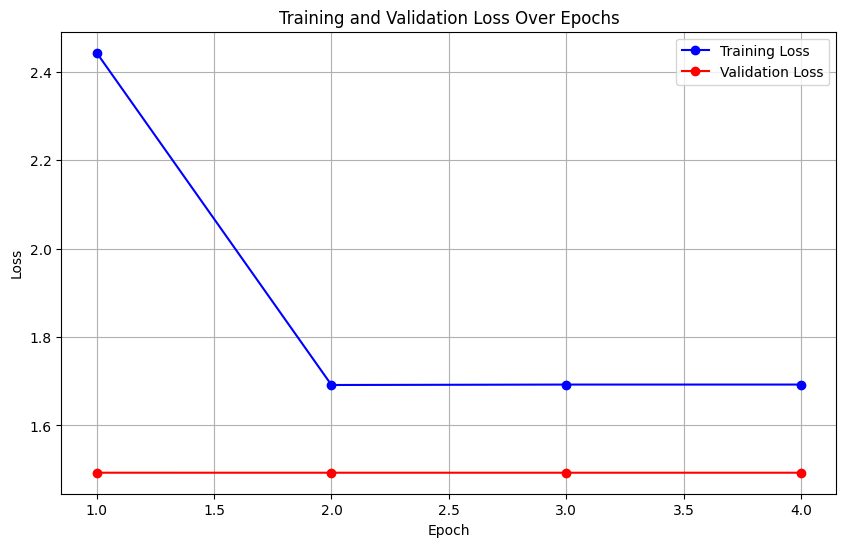

In [ ]:
'''
# Ensure the correct device is used (GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained ProGen model and move it to the appropriate device
model = ProGenForCausalLM.from_pretrained(
    '/data/home/jiawei/class1_test/progen2-large',
    revision='float16',  # Load model with float16 support
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
).to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Track training and validation losses for each epoch
train_losses = []
val_losses = []
accumulation_steps = 8  # Gradient accumulation steps

best_val_loss = float('inf')
patience = 3  # Early stopping patience
patience_counter = 0

# Fine-tuning loop
model.train()  # Set the model to training mode
for epoch in range(4):  # Train for 4 epochs
    epoch_train_loss = 0.0
    num_train_batches = 0

    # Training phase
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
    
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Gradient accumulation and optimizer step
        if (num_train_batches + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        epoch_train_loss += loss.item()
        num_train_batches += 1

    # Compute average training loss
    average_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0.0
    num_val_batches = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in tqdm(val_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            epoch_val_loss += loss.item()
            num_val_batches += 1

    # Compute average validation loss
    average_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(average_val_loss)

    # Early stopping check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        patience_counter = 0  # Reset counter if validation loss improves
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}!")
        break

    # Print training and validation losses for each epoch
    print(f"Epoch {epoch + 1}: Train Loss = {average_train_loss:.4f}, Validation Loss = {average_val_loss:.4f}")

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
'''

#### Save the model
After fine-tuning is complete, save the model and delete model, data and cache:

In [8]:
'''
model.save_pretrained('progen_ADH_finetuned')
# delete model
del model
'''
# delete data
del input_ids
del attention_mask
del train_dataset
del val_dataset
del train_dataloader
del val_dataloader
# clear GPU cache
torch.cuda.empty_cache()


#### Now that we have downloaded our fine-tuned ProGen model, in the next section we will test the model's ability to generate enzymes.

### 1.4 Generate Enzyme

#### Now we will start using progen to generate new enzymes.
### **Please read the notes in the code carefully.**

Imports essential libraries and modules

In [9]:
import os
import time

Define a utility context manager class print_time that measures and displays the execution time of a code block along with a descriptive message.

In [10]:
# Utility functions and classes

# A context manager to measure and print the time taken for a code block
class print_time:
    def __init__(self, desc):
        """
        Initialize with a description of the task.
        :param desc: A string describing the task being timed.
        """
        self.desc = desc

    def __enter__(self):
        """
        When entering the context, print the description and start timing.
        """
        print(self.desc)  # Print the description of the task
        self.t = time.time()  # Record the start time

    def __exit__(self, type, value, traceback):
        """
        When exiting the context, calculate and print the time taken.
        :param type: The exception type (if any occurred during the block).
        :param value: The exception value (if any occurred during the block).
        :param traceback: The traceback (if any exception occurred during the block).
        """
        elapsed_time = time.time() - self.t  # Calculate the elapsed time
        print(f'{self.desc} took {elapsed_time:.02f}s')  # Print the elapsed time with description


Environment Setup Function

In [11]:
# Function to set up the environment variables
def set_env():
    """
    Disable parallelism in tokenizers by setting an environment variable.
    This avoids potential issues when using certain tokenizer libraries in parallelized environments.
    """
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Set random seeds across libraries to ensure reproducibility and optionally enforces deterministic CUDA behavior

In [12]:
# Function to set the random seed for reproducibility
def set_seed(seed, deterministic=True):
    """
    Set the random seed for reproducibility across various libraries and environments.
    :param seed: The seed value to use for randomness.
    :param deterministic: Whether to enforce deterministic behavior in CUDA operations.
    """
    # Set Python's random seed
    random.seed(seed)

    # Set Python's hash seed to ensure consistent hashing
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Set PyTorch's random seed
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        # Set CUDA's random seed for GPU-based computations
        torch.cuda.manual_seed(seed)

        # Configure PyTorch's cuDNN backend for deterministic or non-deterministic behavior
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = not deterministic

Load a pre-trained ProGen model checkpoint for causal language modeling, with optional float16 precision for optimized performance

In [13]:
# Model-related functions

def create_model(ckpt, fp16=True):
    """
    Load a pre-trained ProGen model for causal language modeling.
    :param ckpt: The path to the model checkpoint or a model identifier.
    :param fp16: Whether to load the model in half-precision (float16) for faster inference on supported hardware.
    :return: An instance of ProGenForCausalLM initialized with the specified checkpoint.
    """
    if fp16:
        # Load model in float16 for better performance and lower memory usage on GPU
        return ProGenForCausalLM.from_pretrained(
            ckpt,
            revision='float16',  # Ensure float16-compatible revision is loaded
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True  # Reduce memory usage during model loading
        )
    else:
        # Load model in full precision (default: float32)
        return ProGenForCausalLM.from_pretrained(ckpt)

Load a custom tokenizer from a specified JSON configuration file

In [14]:
def create_tokenizer_custom(file):
    """
    Create a tokenizer from a custom tokenizer file.
    :param file: The path to the tokenizer configuration file (JSON format).
    :return: An instance of Tokenizer loaded from the specified file.
    """
    with open(file, 'r') as f:
        # Read and initialize the tokenizer using the JSON configuration
        return Tokenizer.from_str(f.read())

Generate text samples from a model using nucleus sampling and specified parameters, returning decoded sequences

In [15]:
# Sampling function

def sample(device, model, tokenizer, context, max_length, num_return_sequences, top_p, temp, pad_token_id):
    with torch.no_grad():  # Disable gradient calculation for inference to save memory
        # Encode the input context into token IDs and reshape for input to the model
        input_ids = torch.tensor(tokenizer.encode(context).ids).view([1, -1]).to(device)

        # Generate token sequences from the model using sampling
        tokens_batch = model.generate(
            input_ids,  # The input prompt (tokenized)
            do_sample=True,  # Enable sampling instead of greedy decoding
            temperature=temp,  # Control randomness in predictions
            max_length=max_length,  # Limit the maximum sequence length
            top_p=top_p,  # Use nucleus sampling with specified probability threshold
            num_return_sequences=num_return_sequences,  # Number of sequences to return
            pad_token_id=pad_token_id  # Token ID to use for padding sequences
        )

        # Convert the generated tensor batch into a list of sequences
        as_lists = lambda batch: [batch[i, ...].detach().cpu().numpy().tolist() for i in range(batch.shape[0])]

        # Decode the token sequences into human-readable text and return them
        return tokenizer.decode_batch(as_lists(tokens_batch))

Truncate a string at the first occurrence of any specified terminal character or substring

In [16]:
# Utility functions

def truncate(sample, terminals):
    """
    Truncate a string (sample) at the first occurrence of any terminal character or substring.
    :param sample: The input string to be truncated.
    :param terminals: A list of terminal characters or substrings to search for.
    :return: The truncated string, or the original string if no terminal is found.
    """
    pos = []  # List to store the positions of found terminals
    for terminal in terminals:
        # Find the position of the terminal in the string, starting from index 1
        find_pos = sample.find(terminal, 1)
        if find_pos != -1:  # If the terminal is found
            pos.append(find_pos)  # Add its position to the list

    if len(pos) > 0:
        # If at least one terminal is found, truncate the string at the first occurrence
        return sample[:(min(pos) + 1)]
    else:
        # If no terminal is found, return the original string
        return sample

Compute the cross-entropy loss between model predictions and ground truth labels, with options for reduction type

In [17]:
def cross_entropy(logits, target, reduction='mean'):
    """
    Compute the cross-entropy loss between the predicted logits and the target labels.
    :param logits: Predicted logits from the model (shape: [batch_size, num_classes]).
    :param target: Ground truth labels (shape: [batch_size]).
    :param reduction: Specifies the reduction to apply to the output:
                      - 'none': No reduction is applied.
                      - 'mean': The output loss is averaged over the batch.
                      - 'sum': The output loss is summed over the batch.
    :return: The computed cross-entropy loss.
    """
    return torch.nn.functional.cross_entropy(
        input=logits,  # Predicted logits
        target=target,  # Ground truth labels
        weight=None,  # No class weighting applied
        size_average=None,  # Deprecated parameter, left as default
        reduce=None,  # Deprecated parameter, left as default
        reduction=reduction  # Specify reduction type (e.g., 'mean', 'sum', 'none')
    )

Model and Parameter Definitions

In [18]:
# (0) constants

models_151M = ['progen2-small']
models_754M = ['progen2-medium', 'progen2-oas', 'progen2-base']
models_2B = ['progen2-large', 'progen2-BFD90']
models_6B = ['progen2-xlarge']
models_ADH= ['progen_ADH_finetuned']
models = models_151M + models_754M + models_2B + models_6B+models_ADH

# (1) params

# Define parameters directly in the code
params = {
    "model": "progen_ADH_finetuned",  # If your fine-tuned model does not produce satisfactory results, try using "progen2-large"
    "device": "cuda:0",  # The device to run the model on (e.g., 'cpu', 'cuda:0')
    "rng_seed": 42,  # The random seed for reproducibility
    "rng_deterministic": True,  # Whether to ensure deterministic results (e.g., for reproducibility)
    "p": 0.95,  # The probability parameter for the sampling process (controls diversity)
    "t": 0.5,  # Temperature parameter for controlling the randomness of the predictions (higher t = more random)
    "max_length": 512,  # The maximum length of the generated sequences (in tokens/characters)
    "num_samples": 5,  # The number of protein sequences to generate
    "fp16": True,  # Whether to use half-precision (16-bit) floating point for model inference to save memory and speed up computation
    "context": "AGLGGIGLDTSREIVKSGPKNLVILDRIENPAA",  # The input context (e.g., starting sequence) for generation
    "sanity": True,  # Whether to perform a sanity check before starting the generation
    "output_file": "generated_proteins.fasta"  # The output file path to save the generated protein sequences (in FASTA format)
}

Environment Initialization and Model Loading Workflow

In [19]:
# (2) preamble

set_env()
set_seed(params["rng_seed"], deterministic=params["rng_deterministic"])

if not torch.cuda.is_available():
    print('falling back to cpu')
    params["device"] = "cpu"

device = torch.device(params["device"])
ckpt = f'/data/home/jiawei/class1_test/{params["model"]}'

if device.type == 'cpu':
    print('falling back to fp32')
    params["fp16"] = False

# (3) load

with print_time('loading parameters'):
    model = create_model(ckpt=ckpt, fp16=params["fp16"]).to(device)

with print_time('loading tokenizer'):
    tokenizer = create_tokenizer_custom(file='tokenizer.json')

loading parameters
loading parameters took 57.63s
loading tokenizer
loading tokenizer took 0.00s


Sanity Check for Model Performance

In [20]:
# (4) Sanity check

if params["sanity"]:  # Check if the sanity flag is enabled
    with print_time('sanity cross-entropy'):  # Measure the time taken for sanity check
        # Define a helper function to calculate cross-entropy for given tokens
        def ce(tokens):
            with torch.no_grad():  # Disable gradient computation for inference
                with torch.cuda.amp.autocast(enabled=params["fp16"]):  # Use automatic mixed precision if fp16 is enabled
                    # Encode the input tokens into token IDs
                    target = torch.tensor(tokenizer.encode(tokens).ids).to(device)

                    # Forward pass: compute logits with the model
                    logits = model(target, labels=target).logits

                    # Shift logits and target for causal language modeling
                    logits = logits[:-1, ...]  # Remove the last logit (causal modeling shifts one step ahead)
                    target = target[1:]  # Remove the first target to align with logits

                    # Compute and return the cross-entropy loss
                    return cross_entropy(logits=logits, target=target).item()

        # Define sample sequences and their expected cross-entropy values
        x_uniref90bfd30 = '2GFLPFRGADEGLAAREAATLAARGTAARAYREDSWAVPVPRGLLGDLTARVAALGAASPPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAEAATAAAAATEAYLERLQDFVLFMSASVRVWRRGNAAGATGPEWDQWYTVADRDALGSAPTHLAVLGRQADALCHFVLDRVAWGTCGTPLWSGDEDLGNVVATFAGYADRLATAPRDLIM1'
        x_oas = '1EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMHWVRQAPWKGLEYVSAISSNGGSTYYANSVKGRFTISRDNSKNTLYLQMGSLRAEDMAVYYCARDESGYSYGWGYYFDYWGQGTLVTVSS2'
        x_bfd90 = '1TAPRSTRASGSEGSRPPGIPAKGRRCLPSRAGSVTPRFRHARQGTATVAKEQGRKLIASNRKARHDYHIEDTFEAGLVLTGTEVKSLRMGRASLIDGYAVFYGEELWLEGVHIPEYLNGNWTNHTPRRRRKLLLNRSELTKLAHKTSESGHTIVPLALYFKDGRAKVEIAVAKGKKAYDKRHALRERQDQREV2'
        x_adh='MALSLTNKNVVFVAGLGGIGLDTTKELLKRDLKNLVILDRIDNPTVIAELKTINPKVTVTFIPYDVTVPITETKKLLKTIFDKLKTVDILINGAGILDDHQIERTIAVNYTGLVNTTTAILDFWDKRKGGPGGIICNIGSVTGFNAIYQVPVYSGTKAAVVNFTSSLAKLAPITGVTAYTVNPGITRTTLVHKFNSWLDVEPQVAEKLLAHPTQSSQACGENFVKAIELNQNGAIWKLDRGTLEAIQ'


        # Map models to their respective test sequences and target cross-entropy values
        checkpoint_x_ce = {
            'progen2-small': (x_uniref90bfd30, 2.4),
            'progen2-medium': (x_uniref90bfd30, 1.9),
            'progen2-base': (x_uniref90bfd30, 1.9),
            'progen2-large': (x_uniref90bfd30, 1.8),
            'progen2-xlarge': (x_uniref90bfd30, 1.0),
            'progen2-oas': (x_oas, 0.3),
            'progen2-BFD90': (x_bfd90, 1.3),
            'progen_ADH_finetuned': (x_adh, 2.8)
        }

        # Evaluate cross-entropy on the test sequence corresponding to the current model
        ce_eval = ce(checkpoint_x_ce[params["model"]][0])  # Compute evaluated cross-entropy
        ce_target = checkpoint_x_ce[params["model"]][1]  # Target (expected) cross-entropy

        # Print the expected, evaluated, and difference in cross-entropy
        print(f"Expected cross-entropy (ce_target): {ce_target}")
        print(f"Evaluated cross-entropy (ce_eval): {ce_eval}")
        print(f"Difference (abs(ce_eval - ce_target)): {abs(ce_eval - ce_target)}")

        # Ensure the evaluated cross-entropy is within an acceptable range of the target
        if abs(ce_eval - ce_target) < 0.1:
            print("Sanity check succeeded: Cross-entropy match")
        else:
            print("Sanity check failed: Cross-entropy mismatch")

sanity cross-entropy
Expected cross-entropy (ce_target): 2.8
Evaluated cross-entropy (ce_eval): 2.8202455043792725
Difference (abs(ce_eval - ce_target)): 0.02024550437927264
Sanity check succeeded: Cross-entropy match
sanity cross-entropy took 0.28s


Sampling and Output Saving Workflow

In [21]:
# (5) sample

with print_time('sampling'):
    completions = sample(
        device=device,
        model=model,
        tokenizer=tokenizer,
        context=params["context"],
        pad_token_id=tokenizer.encode('<|pad|>').ids[0],
        num_return_sequences=params["num_samples"],
        temp=params["t"],
        top_p=params["p"],
        max_length=params["max_length"]
    )
    # Truncate each generated sequence at the first occurrence of terminal tokens ('1', '2')
    truncations = [truncate(completion, terminals=['1', '2']) for completion in completions]

    # Print the input context for reference
    print(f'The initial enzyme sequence is: {params["context"]}')

    print("The generated enzyme sequences are as follows:")
    # Print the generated (and truncated) sequences
    for i, truncation in enumerate(truncations):
        print()  # Add a blank line for readability
        print(i)  # Print the sequence index
        print(truncation)  # Print the truncated sequence

    # Save the generated sequences to a FASTA file
    fasta_filename = params["output_file"]  # Get the output file name from parameters
    with open(fasta_filename, "w") as fasta_file:
        for i, truncation in enumerate(truncations):
            # Write each sequence in FASTA format: >header followed by the sequence
            fasta_file.write(f">Sample_{i}\n")  # Header line for each sequence
            fasta_file.write(f"{truncation}\n")  # The sequence itself

    # Confirm that the sequences have been saved
    print(f"Generated sequences saved to {fasta_filename}")

sampling
The initial enzyme sequence is: AGLGGIGLDTSREIVKSGPKNLVILDRIENPAA
The generated enzyme sequences are as follows:

0
AGLGGIGLDTSREIVKSGPKNLVILDRIENPAAGTELVLAGVSAAAGLALLGTGDGASALGLAEAEGDGELGGEGFALPSVLAKGLGTALNPIAIEAETVEVGALELDVRGRDEKGILLDREAAINLTSDAPRILNIGGITGAVGGLDAVNRGPTGLAGLGGAAVRVRAVIVTVAEGLAGVGVKGAVVGVVGAVEGTVAFLAVGAEAVLVKAGVVGELAIVTAAKGADNKVAGVTGGESGVIEAELGGLLGAVARAGVIVELAKKLGAGAAALGPLEAGVVTREFLPGPAGKGPGTVPGPTSLGLVLALLLKRPIVLVADGVGEGIGGAGVPGVVPLAPPAGLDASLKAGAIKIDEVAIEDEATTGVGASAEGIKAEAGFDNVAVVRALLVGGVGSAASSGVVDAGVTGGGKSKSVKEPATGALLAKAKDADAAIPGIFLGGSVGKKPLAPREFATAIVATVGALVVVGAAEGIRDIADITGARRAPLAIVRGRLGGGRRPVGLADDPKALT

1
AGLGGIGLDTSREIVKSGPKNLVILDRIENPAASAVLRIGAVARIGAGPGREAALVTGGLSALGVPVVGALVVPQEELTVVTAAVPTAVGIVTVLRTGLGAAILIAVVSAEEGGIRVVEAGSVEAVVPLGGVEALDKELAKPSVVVLGVTNKSLSIDGLLGSGVVGVAGVAGLISTAGEADAIEKVNTPGGEFIELLRGALTKGDRKGGTAEGLALDEAADAVNVVGADLTLAVAKVLASAGAARAIAVDEALTAEEIEAVDPAVPEVTAVEDADLSEAIDLVFALFGGGLAVNGSGGVDNAGTVKAILDLSAAPEADAAGVPLLLVTAAVITLTAIAVGDKETDAVGGVPVGGGKTIA

##### Question 1 Please change the relevant parameters to generate new enzyme sequences, then write down your parameters.
________________________________________________________________________________________________

##### Question 2 You can use likelihood.py to score the sequences you generated previously, write down the sequence with the largest score.(Please change input_file to your fasta file, the meaning of the score will be mentioned in the fifth part, Please see likelihood.py for details)
________________________________________________________________________________________________

In [ ]:
!python3 likelihood.py --model "progen2-large" --input_file "generated_proteins.fasta" --output_file "log_likelihood_progen.csv"

## 2. Convert the ADH natural sequence dataset fasta file to a tsv file

#### In order to use the ESM-MSA model, we first need to convert the fasta file into a tsv file including seed sequences. The written data format is as follows:
- **test_seq	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order':False, 'num_positions_percent': 10, 'top_k': 1, 'seed_seq': "MEPAATGQEAEECAHSGRGEAWEEV"}**
- **test_seq2	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order':False, 'num_positions_percent': 10, 'top_k': 1, 'seed_seq': "MLEGADIVIIPAGV"}**
#### **Note that the data format is a dictionary!**
#### **Please change the fasta file path and the tsv file save path to your relevant file path.**

(1) Data format preparation

In [23]:
from Bio import SeqIO
import csv

# Path to the input FASTA file
fasta_file = "ADH_Drosophila.fasta"

# Output TSV file path
tsv_file = "pgen_esm.tsv"

# Templates with fixed parameters
template_params = {
    "num_iters": 20,  # Number of iterations for the process (e.g., sampling or optimization)
    "burnin": 10,  # Number of initial iterations to discard as "burn-in" to improve quality
    "mask": True,  # Whether to apply masking to certain positions (e.g., for sampling or training)
    "in_order": False,  # Whether to process sequences in a fixed order (True) or randomly (False)
    "num_positions_percent": 10,  # Percentage of positions to include in the process (e.g., sampling)
    "top_k": 1  # Select the top-k results, with 1 meaning only the best result
}

(2) tsv file generation

In [24]:
# Read FASTA file and write TSV file
with open(fasta_file, "r") as fasta, open(tsv_file, "w", newline="", encoding="utf-8") as tsv:
    writer = csv.writer(tsv, delimiter="\t")
    
    for record in SeqIO.parse(fasta, "fasta"):
        sequence_id = record.id  # Get sequence IDs from FASTA
        sequence = str(record.seq)  # Get sequences from FASTA
        # Creating dictionary data
        params = template_params.copy()
        params["seed_seq"] = sequence  # Add a sequence to a dictionary
        
        # Write to TSV file, the second column directly stores the dictionary
        writer.writerow([sequence_id, params])

print(f"The sequence and parameters have been successfully written to the TSV file: {tsv_file}")

The sequence and parameters have been successfully written to the TSV file: pgen_esm.tsv


##### Question 3 In addition to the dictionary just now, we also need to write the following dictionary in another tsv file(The seed sequences come from fasta files):
- **test_seq	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order':False, 'num_positions_percent': 10, 'top_k': 1}	fasta_input1.fasta**
- **test_seq2	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order':False, 'num_positions_percent': 10, 'top_k': 1}	fasta_input2.fasta**  
##### Please enter the code that implements it.
________________________________________________________________________________________________

In [ ]:
#Type your code

## 3. Designing enzymes using ESM-MSA

### 3.1 Introduction to ESM-MSA

ESM-MSA (Evolutionary Scale Modeling - Multiple Sequence Alignment) is a protein language model developed by Meta (formerly Facebook) AI research team, which aims to capture evolutionary information in protein sequences through multiple sequence alignment (MSA) data. Compared with traditional single sequence models, ESM-MSA uses MSA data to more accurately predict protein structure and function.
- **Principle**: ESM-MSA is based on the Transformer architecture and is specifically designed for multiple sequence alignment (MSA) data.
  - **Row attention**: captures the evolutionary relationship between sequences.
  - **Column attention**: identifies patterns and features within sequences.
  - Using the evolutionary information of MSA, the correlation between protein sequences is extracted, which is more accurate than the single sequence model.
- **Function**: 
  - **Protein contact prediction**: infer the interaction of protein residues through sequence relationships.
  - **Function annotation**: provide functional inferences for unknown sequences.
  - **Mutation effect assessment**: analyze the impact of amino acid variation on function.
- **Applications**:
  - **Structural biology**: predicting protein three-dimensional structure.
  - **Drug design**: screening for molecules that interact with proteins.
  - **Evolutionary research**: analyzing the evolutionary history and functional conservation of proteins.
  - **Genetics**: studying the effects of genetic variation on protein function.

### 3.2 Setup

To use ESM-MSA, please execute the following commands first **line by line**:
```
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0%2Bcu118/torch_scatter-2.1.2%2Bpt23cu118-cp38-cp38-linux_x86_64.whl 
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0%2Bcu118/torch_sparse-0.6.18%2Bpt23cu118-cp38-cp38-linux_x86_64.whl 
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.3.0%2Bcu118/torch_cluster-1.6.3%2Bpt23cu118-cp38-cp38-linux_x86_64.whl 
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0%2Bcu118/torch_spline_conv-1.2.2%2Bpt23cu118-cp38-cp38-linux_x86_64.whl 
pip install torch-geometric
pip install git+https://github.com/facebookresearch/esm.git
```

### 3.3 Generate Enzyme

#### 3.3.1 Use the seed sequence directly

##### Now we will start using ESM-MSA to generate new enzymes .
##### **Please read the notes in the code carefully.**

Imports essential libraries and modules

In [25]:
from pgen.esm_sampler import ESM_sampler
import esm
from pathlib import Path
import sys
from typing import Sequence, Tuple, Union
from pgen.utils import write_in_fasta, RawAndDefaultsFormatter

Raw Sequence Batch Length Calculation

In [26]:
RawMSA = Sequence[Tuple[str, str]]

# Helper function: Calculate the length of a raw sequence batch
def rawbatchlen(raw_batch: str):
    """
    Counts the number of characters in a sequence batch,
    excluding characters within angled brackets (<, >).
    """
    count = 0
    counting = True
    for ch in raw_batch:
        if ch == "<":
            counting = False
        if ch == ">":
            counting = True
        if counting:
            count += 1
    return count

Custom MSABatchConverter for MSA Data

In [27]:
# Custom MSABatchConverter: Modified version of esm.data.MSABatchConverter
class MSABatchConverter(esm.data.BatchConverter):
    """
    Custom implementation of MSABatchConverter for processing MSA (Multiple Sequence Alignment) data.
    """
    def __call__(self, inputs: Union[Sequence[RawMSA], RawMSA]):
        if isinstance(inputs[0][0], str):
            # If the input is a single MSA
            raw_batch: Sequence[RawMSA] = [inputs]
        else:
            raw_batch = inputs

        batch_size = len(raw_batch)
        max_alignments = max(len(msa) for msa in raw_batch)  # Max number of alignments in the batch
        max_seqlen = max(rawbatchlen(msa[0][1]) for msa in raw_batch)  # Max sequence length in the batch
        tokens = torch.empty(
            (
                batch_size,
                max_alignments,
                max_seqlen + int(self.alphabet.prepend_bos) + int(self.alphabet.append_eos),
            ),
            dtype=torch.int64,
        )
        tokens.fill_(self.alphabet.padding_idx)  # Fill with padding index
        labels = []
        strs = []
        for i, msa in enumerate(raw_batch):
            # Ensure all sequences in the MSA are of the same length
            msa_seqlens = set(rawbatchlen(seq) for _, seq in msa)
            if not len(msa_seqlens) == 1:
                raise RuntimeError(
                    "Received unaligned sequences for input to MSA. All sequence lengths must be equal."
                )
            msa_labels, msa_strs, msa_tokens = super().__call__(msa)
            labels.append(msa_labels)
            strs.append(msa_strs)
            tokens[i, : msa_tokens.size(0), : msa_tokens.size(1)] = msa_tokens
        return labels, strs, tokens

Custom ESM Model Initialization Classes

In [28]:
# Replace the default MSABatchConverter in esm with the custom implementation
esm.data.MSABatchConverter = MSABatchConverter

# Define classes for different ESM models

class ESM1b:
    def __init__(self):
        """
        Initializes the ESM1b model.
        """
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm1b_t33_650M_UR50S.pt')
        self.batch_converter = self.alphabet.get_batch_converter()

class ESM1v:
    def __init__(self):
        """
        Initializes the ESM1v model.
        """
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm1v_t33_650M_UR90S_1.pt')
        self.batch_converter = self.alphabet.get_batch_converter()

class ESM6:
    def __init__(self):
        """
        Initializes the ESM6 model.
        """
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm1_t6_43M_UR50S.pt')
        self.batch_converter = self.alphabet.get_batch_converter()

class ESM12:
    def __init__(self):
        """
        Initializes the ESM12 model.
        """
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm1_t12_85M_UR50S.pt')
        self.batch_converter = self.alphabet.get_batch_converter()

class ESM34:
    def __init__(self):
        """
        Initializes the ESM34 model.
        """
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm1_t34_670M_UR50S.pt')
        self.batch_converter = self.alphabet.get_batch_converter()

class ESM_MSA1:
    def __init__(self):
        """
        Initializes the ESM_MSA1 model for MSA tasks.
        """
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm_msa1b_t12_100M_UR50S.pt')
        # self.msa_transformer = model.eval().cuda()
        self.batch_converter = self.alphabet.get_batch_converter()

ESM Model Selection and Sampling Setup

In [ ]:
# Define a mapping of model names to their corresponding model classes
model_map = {
    "esm1b": ESM1b,
    "esm6": ESM6,
    "esm12": ESM12,
    "esm34": ESM34,
    "esm1v": ESM1v
}

# Parameters are directly defined here
output_directory = "pgen_out"  # Directory to save the output files
input_file_path = "pgen_esm.tsv"  # Path to the input file
batch_size = 1  # Number of sequences generated per batch
num_output_sequences = 2  # Total number of sequences to generate
device = "gpu"  # Device to use for computation, either "cpu" or "gpu"
model_name = "esm1v"  # The model to use, choose from esm1b, esm6, esm12, esm34, esm1v
output_fasta= "generated_sequences_pgen.fasta" #Store the file name where the generated sequences will be saved in FASTA format

# Initialize the sampler with the specified model and device
sampler = ESM_sampler(model_map[model_name](), device=device)

# Create the output directory if it does not already exist
output_path = Path(output_directory)
output_path.mkdir(exist_ok=True)

Input File Processing and Sequence Generation Workflow

In [ ]:
# Open the input file for reading, or use stdin if no file is specified
if input_file_path:
    input_handle = open(input_file_path, "r")
else:
    input_handle = sys.stdin

file_path = f'{output_path}/{output_fasta}'

# Whether the file exists
if os.path.exists(file_path):
    # Open the FASTA file and clear the contents
    with open(file_path, 'w') as file:
        file.truncate(0)

# Open the output file to write the specification details
with open(output_path / "specification.tsv", "w") as output_h:
    # Process each line in the input file
    i=0
    for line in input_handle:
        line = line.strip()  # Remove leading/trailing whitespace
        if len(line) == 0:  # Skip empty lines
            continue
        line = line.split("\t")  # Split the line by tab characters
        if len(line) == 2:
        # If the line contains exactly two columns: name and arguments
            print("\t".join(line))  # Print to console
            print("\t".join(line), file=output_h)  # Write to the output file
            name = line[0]  # Extract the sample name
            line_args = eval(line[1])  # Evaluate the string to extract arguments (use with caution)
            
            # Generate sequences using the sampler
            sequences= sampler.generate(
                num_output_sequences,
                batch_size=batch_size,
                **line_args
            )
            #print(sequences)
            # Save the generated sequences to a FASTA file
            write_in_fasta(output_path / output_fasta, i, sequences)
            i+=1
        else:
            # If the line does not have exactly two columns, log an error
            print(f"Expected 2 values in specification file (name, line_args), got {len(line)}")
            print("\t".join(line))

# Close the input file if it was opened from a file path
if input_file_path:
    input_handle.close()

##### Question 4 Please change the relevant parameters to generate new enzyme sequences, then write down your parameters.
________________________________________________________________________________________________

#### 3.3.2 The seed sequences come from fasta files, instead of being defined in the sampler arguments. 

Similar to the previous section, except that the seed sequence comes from the fasta file instead of being defined in the sampler parameters. The sequences in fasta can be aligned or unaligned. If aligned, gaps are removed before sampling, but setting --keep_gap_positions will add gaps back after sampling. If fasta contains multiple sequences, a random sequence is chosen for each round of sampling.

Imports and Utilities for Sequence Sampling and Processing

In [34]:
from pgen.esm_sampler import ESM_sampler
from pgen.utils import parse_fasta, unalign, add_gaps_back

Model Mapping and Sampling Configuration

In [ ]:
# Mapping of model names to their corresponding classes
model_map = {
    "esm1b": ESM1b,
    "esm6": ESM6,
    "esm12": ESM12,
    "esm34": ESM34,
}

# Parameters directly defined in the script
output_directory = "pgen_from_fasta_out"  # Directory to save outputs
input_file_path = "pgen_esm_from_fasta.tsv"  # Path to the input file
batch_size = 1  # Batch size for sampling (must be 1)
num_output_sequences = 10  # Total number of sequences to generate
device = "gpu"  # Device to use: "cpu" or "gpu"
model_name = "esm1b"  # Model to use: "esm1b", "esm6", "esm12", or "esm34"
keep_gap_positions = True  # Whether to retain gap positions in the output
output_fasta= "generated_sequences_pgen_from_fasta.fasta" #Store the file name where the generated sequences will be saved in FASTA format

# Initialize the sampler with the selected model and device
sampler = ESM_sampler(model_map[model_name](), device=device)

# Ensure the output directory exists
output_path = Path(output_directory)
output_path.mkdir(exist_ok=True)

Input File Processing and Sequence Generation from FASTA

In [42]:
file_path = f'{output_path}/{output_fasta}'

# Whether the file exists
if os.path.exists(file_path):
    # Open the FASTA file and clear the contents
    with open(file_path, 'w') as file:
        file.truncate(0)  

# Open the input file for reading
with open(input_file_path, "r") as input_handle:
    # Open the output specification file for writing
    with open(output_path / "specification.tsv", "w") as output_h:
        for line in input_handle:
            line = line.strip()  # Remove whitespace
            if len(line) == 0:
                continue  # Skip empty lines
            line = line.split("\t")  # Split the line into columns

            if len(line) == 3:
                # If the input line has the correct format: [name, args, fasta_path]
                print("\t".join(line))  # Print to console for logging
                print("\t".join(line), file=output_h)  # Write to the specification file

                # Extract name, arguments, and seed sequences
                name = line[0]
                line_args = eval(line[1])  # Convert arguments from string to dict
                seeds = parse_fasta(line[2], clean=None)  # Parse the fasta file

                sequences = []  # Store generated sequences
                for _ in trange(num_output_sequences):
                    # Randomly select a seed sequence and process it
                    seed = random.choice(seeds)
                    seed, gap_mask = unalign(seed)

                    # Generate a new sequence using the sampler
                    generated_sequence = sampler.generate(
                        n_samples=1,
                        seed_seq=seed,
                        batch_size=batch_size,
                        show_progress_bar=False,
                        **line_args
                    )[0]

                    # Reintroduce gaps if the option is enabled
                    if keep_gap_positions:
                        generated_sequence = add_gaps_back(generated_sequence, gap_mask)

                    sequences.append(generated_sequence)
                #print(sequences)
                # Save the generated sequences to a fasta file
                write_in_fasta(output_path / output_fasta, 0, sequences)
            else:
                print(f"Error: Expected 3 columns in the input, but got {len(line)}.")
                print("\t".join(line))

ADH_Drosophila	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order': False, 'num_positions_percent': 10, 'top_k': 1}	ADH_Drosophila.fasta


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


ADH_Drosophila_all_equal	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order': False, 'num_positions_percent': 10, 'top_k': 1}	ADH_Drosophila_all_equal.fasta


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


##### Question 5 Please change the relevant parameters to generate new enzyme sequences, then write down your parameters.
________________________________________________________________________________________________

#### 3.3.3 Multiple sequence alignment using multiple fasta files to generate enzyme sequences

Given a seed msa, uses esm-msa to generate new sequences.

This program will randomly mask and resample across the entire MSA.

Imports for MSA Sampling and Sequence Utilities

In [43]:
from pgen.esm_msa_sampler import ESM_MSA_sampler
from pgen.utils import SequenceSubsetter
import math

### **Attention!!** 
If your fasta file contains many sequences, please make sure that the sequences have the same length.

MSA Model Configuration and Sampling Parameters

In [ ]:
# Mapping of model names to their corresponding classes
model_map = {"esm_msa1": ESM_MSA1}

# Parameters directly defined in the script
output_directory = "pgen_msa_out"  # Directory to save the outputs
input_file_path = "pgen_msa.tsv"  # Path to the input file
batch_size = 1  # Batch size for sampling (must be 1)
num_output_sequences = 165  # Actually, the number of generated sequences is num_output_sequences/alignment_size
device = "gpu"  # Device to use: "cpu" or "gpu"
model_name = "esm_msa1"  # Model to use: "esm_msa1"
delete_insertions = False  # Whether to delete insertions (lowercase and '.' characters)
alignment_size = 32  # Number of sequences to sample from the input alignment
keep_first_sequence = False  # Whether to keep the first sequence during subsetting
subset_strategy = "random"  # Strategy for subsetting the input alignment
output_fasta= "generated_sequences_pgen_msa.fasta" #Store the file name where the generated sequences will be saved in FASTA format

# Set the clean flag based on the delete_insertions parameter
clean_flag = "upper" if not delete_insertions else "delete"

# Initialize the Gibbs sampler with the selected model and device
gibbs_sampler = ESM_MSA_sampler(model_map[model_name](), device=device)

# Ensure the output directory exists
output_path = Path(output_directory)
output_path.mkdir(exist_ok=True)

MSA Input Processing and Batch Generation Workflow.  
(**the number of generated sequences is num_output_sequences/alignment_size**)

In [48]:
file_path = f'{output_path}/{output_fasta}'

# Whether the file exists
if os.path.exists(file_path):
    # Open the FASTA file and clear the contents
    with open(file_path, 'w') as file:
        file.truncate(0)  

# Open the input file
with open(input_file_path, "r") as input_handle:
    # Open the output specification file for writing
    with open(output_path / "specification.tsv", "w") as output_h:
        for line in input_handle:
            line = line.strip()  # Remove whitespace
            if len(line) == 0:
                continue  # Skip empty lines
            line = line.split("\t")  # Split the line into columns

            if len(line) == 3:
                # If the input line has the correct format: [name, args, fasta_path]
                print("\t".join(line))  # Print to console
                print("\t".join(line), file=output_h)  # Write to the specification file

                # Extract name, arguments, and input MSA
                name = line[0]
                line_args = eval(line[1])  # Convert arguments from string to dict
                input_msa = parse_fasta(line[2], clean=clean_flag)  # Parse the MSA file

                # Determine alignment size
                align_size = alignment_size if alignment_size != sys.maxsize else len(input_msa)

                # Calculate the number of batches required
                batches = math.ceil(num_output_sequences / align_size)
                sequences = []  # List to store generated sequences

                # Loop through each batch
                for _ in trange(batches):
                    # Subset the input MSA
                    batch_msa = SequenceSubsetter.subset(
                        input_msa, align_size, keep_first_sequence, subset_strategy
                    )
                    # Generate sequences using the Gibbs sampler
                    sequences += gibbs_sampler.generate(
                        n_samples=len(batch_msa),
                        seed_msa=batch_msa,
                        batch_size=batch_size,
                        show_progress_bar=False,
                        **line_args,
                    )

                # Write the generated sequences to a fasta file
                write_in_fasta(output_path / output_fasta, 0, sequences)
            else:
                # Log an error if the input line is malformed
                print(f"Expected 3 values in specification file (name, line_args, input_msa), got {len(line)}")
                print("\t".join(line))

ADH_Drosophila_all_equal	{'num_iters': 20, 'burnin': 10, 'mask': True, 'in_order': False, 'num_positions_percent': 10, 'top_k': 1}	ADH_Drosophila_all_equal.fasta


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


##### Question 6 Please change the relevant parameters to generate new enzyme sequences, then write down your parameters.
________________________________________________________________________________________________

##### Question 7 You can use likelihood.py to score the sequences you generated previously, write down the sequence with the largest score.(Please change input_file to your fasta file and change output_file to your csv file, the meaning of the score will be mentioned in the fifth part, Please see likelihood.py for details)
________________________________________________________________________________________________

##### Question 8 Please compare the two models based on the data results. You can use the median, mean, etc. to make judgments.
________________________________________________________________________________________________

## 4. Enzyme structure prediction

In order to carry out the fifth step: evaluate the generated enzyme sequence, we must obtain the pdb file of the enzyme sequence, so we need to use AlphaFold to predict the structure of the generated sequence.

### 4.1 Introduction to AlphaFold

AlphaFold is an artificial intelligence-based protein structure prediction system developed by DeepMind. Its main goal is to accurately predict the three-dimensional structure of proteins through computational methods. Protein structure determines their function, so accurate protein structure prediction is of great significance for understanding biological mechanisms, drug development, and disease research.
- **Technical principle:**:
  - **Deep learning model**: AlphaFold uses deep learning technology, especially convolutional neural network (CNN) and Transformer model to process protein sequence data. AlphaFold can infer the spatial structure from the sequence by learning the relationship between protein amino acids.
  - **Training data**: Through a large amount of public protein structure data and amino acid sequence data, AlphaFold trained a deep neural network that can capture the interaction rules between amino acids.
  - **Accuracy**: AlphaFold can not only predict the main chain structure of the protein, but also predict the side chain position in the protein, which makes its prediction accuracy much higher than traditional calculation methods.
- **Application and Impact**:
  - **Biological Research**: The success of AlphaFold has enabled the prediction of a large number of protein structures, greatly accelerating the development of protein structural biology. Many previously unresolvable protein structures, such as some important proteins in the human proteome, can now be predicted by AlphaFold.
  - **Drug Design and Disease Research**: By accurately predicting the three-dimensional structure of proteins, AlphaFold provides a new way to discover and design drug targets. For example, AlphaFold can be used to reveal viral protein structures, which helps develop antiviral drugs and vaccines.
  - **Open Data and Sharing**: DeepMind has made AlphaFold's prediction data and related models open to scientific researchers around the world to help advance scientific research in various fields.
  - **Interdisciplinary Impact**: In addition to life sciences, AlphaFold's technology may also play a role in fields such as materials science, because protein folding is closely related to the properties of many materials (such as catalysis, conductivity, etc.).

### 4.2 How to use AlphaFold

Next, we will introduce two methods. You can choose one of them (choose one of question 9 and question 10). First, make sure you have a Google account.

#### 4.2.1 ColabFold

ColabFold is an open source tool that aims to provide a simple, easy-to-use interface for protein structure prediction through Google Colab, especially using AlphaFold and other structure prediction algorithms. ColabFold enables users without high-performance computing resources to use the power of AlphaFold to predict the three-dimensional structure of proteins.  
ColabFold runs on Google Colab, and users do not need to configure a complex hardware environment. They can use the GPU resources provided by Colab for free for prediction.ColabFold provides users with a simple interface, and only needs to upload protein sequences to quickly predict structures. In addition to AlphaFold prediction, it also integrates some other practical tools, such as polymer structure prediction, structure alignment, etc.  
Users can directly input the amino acid sequence of the protein, and ColabFold will output its three-dimensional structure.It can process multiple protein sequences, align them, and predict polymer structures. 

#### 4.2.1.1 How to use ColabFold

ColabFold URL: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb  
**Through the tips, codes and codes' notes on the ColabFold page, you can learn how to use ColabFold.**

##### Question 9 ColabFold can only input one sequence at a time. You can modify its code to make it predict all sequences in a fasta file directly.(For this problem, you only need to type the first part of the ColabFold code you modified, the first part title is **"Input protein sequence(s), then hit Runtime -> Run all"**, but in ColabFold you need to change all)  
**`Hint:`**   
`1. use biopython 2. uploaded = files.upload() Function: Pop up a file selection dialog box to allow users to select a file to upload.It` `returns a dictionary, the key is the file name, the value is the content of the file (stored in bytes)`
`3.fasta_file = list(uploaded.keys())[0]  uploaded.keys() returns all the file names of the uploaded files (i.e. all the keys of the dictionary).`
`list(uploaded.keys())[0] converts the keys into a list and gets the file name of the first file. `
________________________________________________________________________________________________

In [ ]:
#Type your code

#### 4.2.1.2 Predictive Document Analysis

If the prediction is completed successfully, you can get a compressed package.  
  
![](1732276251894.png)   
  
Unzip it and you will find many pdb files. These are the pdb files of the predicted sequences (arranged according to the pLDDT scores). You can use any of them.  
  
![](1732276352144.png)

### 4.2.2 AlphaFold3(Web version)

#### 4.2.2.1 How to use AlphaFold3(Web version)

If you don’t have enough money to buy a colab GPU, you can use the web version of AlphaFold3 to generate sequence structure predictions.  
URL: https://alphafoldserver.com/  
**Enter your enzyme sequences here.(Attention!! Each account can only predict 20 enzyme sequences every day)**  
  
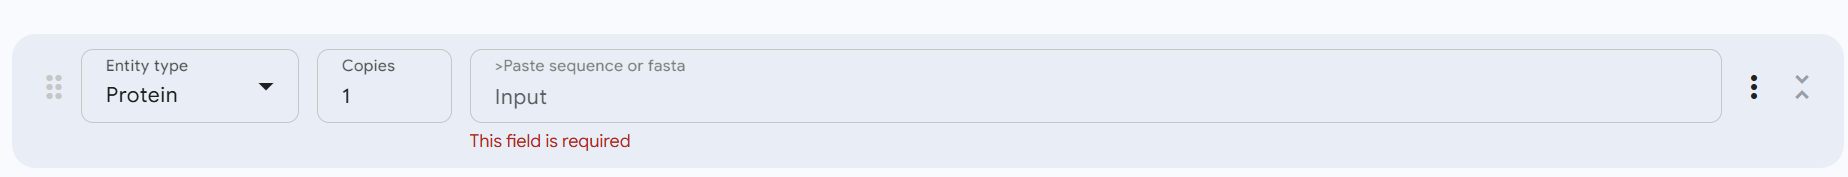
  
**You can also convert the fasta file into a json file and upload it.**  
  
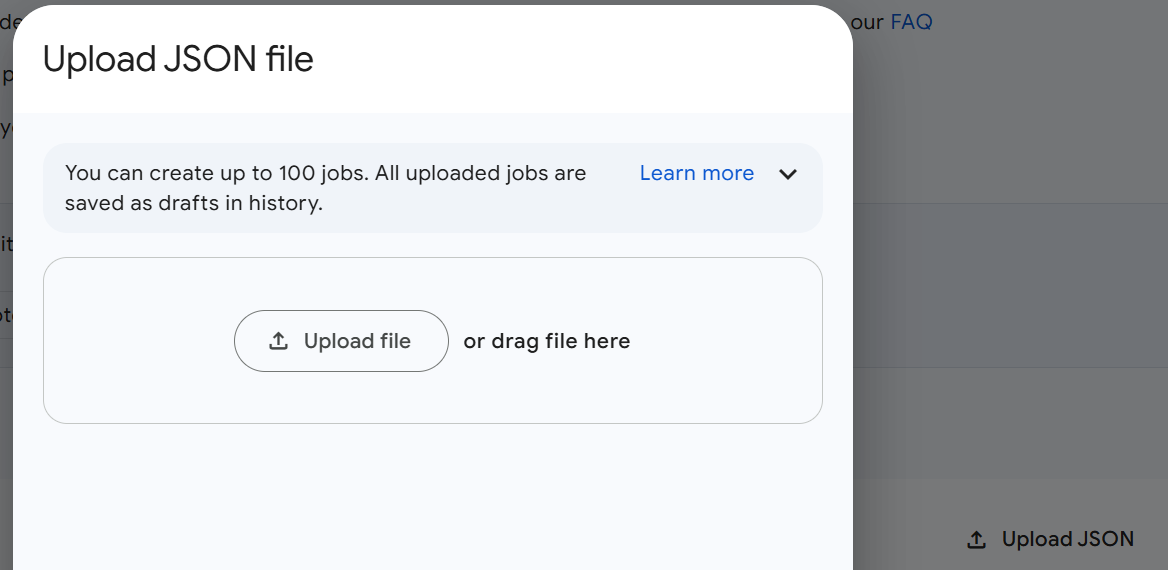  
  
**After the prediction is completed, click "download" to download the prediction results.**  
  
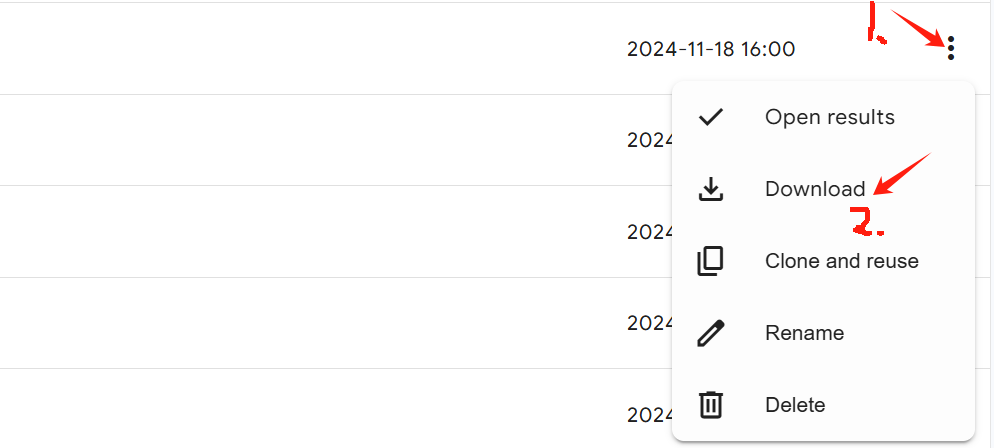  

#### 4.2.2.2 PyMOL

If the prediction is completed successfully, you can get a compressed package.  
  
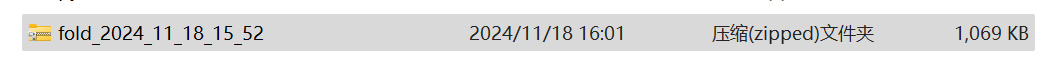  
  
Unzip it and you will find that there are no pdb files, only CIF files.  
  
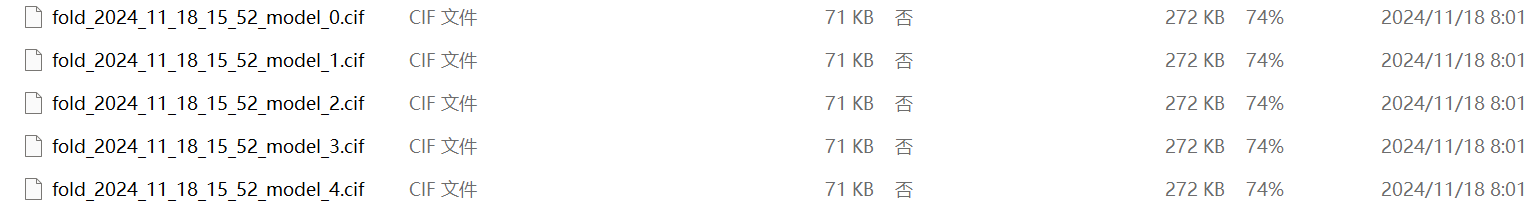  
  
But what we need is the PDB file. Fortunately, we can use PyMOL to convert the CIF file into a PDB file.

PyMOL is an open source molecular visualization tool mainly used in biology and chemistry. It is powerful and allows users to create high-quality molecular models and images. It supports a variety of molecular file formats, such as PDB, MOL, SDF, etc.   
**Most importantly, PyMOL provides scripting support. Users can use PyMOL command language (PML) or Python scripts to operate and automate tasks, and can extend functions through plug-ins and integrate multiple tools.**   
PyMOL supports Windows, MacOS and Linux systems.  
Here is the download tutorial of pymol(**Anaconda needs to be pre-installed**):  
https://blog.csdn.net/monkeny/article/details/127437448

##### Question 10 Write a script in the local interpreter to convert multiple CIF files into PDB files. Before doing this, you'd better put all CIF files into the same folder.
`Hint: import os; from pymol import cmd`
________________________________________________________________________________________

In [ ]:
#Type your code

Then enter run path/to/yourscript.py in the **PyMOL>** command line

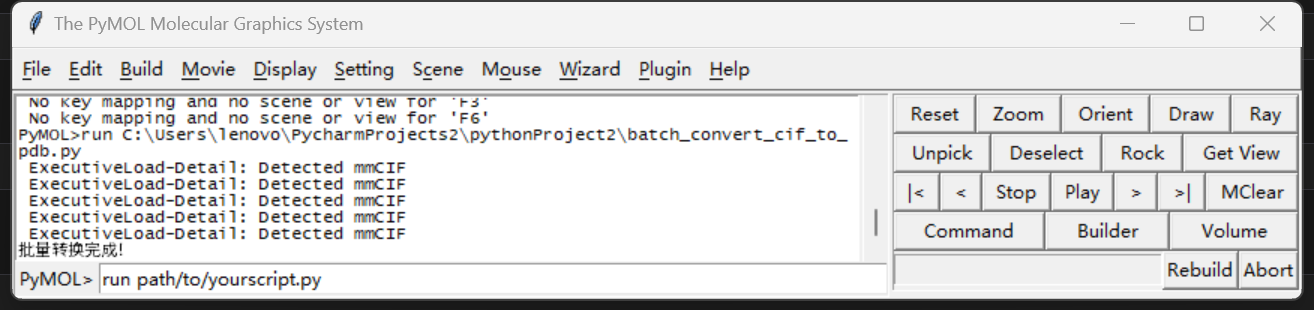  
  
Then you can find the corresponding PDB files in the path you set in advance.

## 5. Evaluation of enzyme sequence and structure using multiple models

### 5.1 Setup
Please execute the following commands **line by line** to install the necessary dependencies:
```
pip install biotite
pip install pytest-datadir~=1.4.1
pip install sequence-models
cd class5
git clone https://github.com/dauparas/ProteinMPNN.git
cd ProteinMPNN
git checkout 0a721279f6706478193f50dff9c1e5ff96214778
```

### 5.2 Reset calculated metrics (creates a new datastructure to store results, clearing any existing results)

Setup for Protein Sequence Analysis and Utilities

In [54]:
results = dict()
device = 'cuda:0'

import re

#from sequence_models.utils import parse_fasta
from typing import List
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from glob import glob
from random import randrange
from biotite.structure.io import pdb
from biotite.structure import get_residue_count
from biotite.structure.residues import get_residues
from biotite.sequence import ProteinSequence
import tempfile
from Bio.Align import substitution_matrices
import subprocess
from dataclasses import dataclass

from sequence_models.pretrained import load_model_and_alphabet
from sequence_models.pdb_utils import parse_PDB, process_coords

Functions for PDB Analysis and Metrics Calculation

In [55]:
def residues_in_pdb(pdb_path):
    with open(pdb_path) as f:
        pdb_file = pdb.PDBFile.read(pdb_path)
        atoms  = pdb_file.get_structure()
    return get_residue_count(atoms)

gap_open=10
gap_extend=2

def add_metric(metrics_dict, protein_name, metric_name, value):
  if protein_name not in metrics_dict:
    metrics_dict[protein_name] = dict()
  metrics_dict[protein_name][metric_name] = value

def get_pdb_sequence(pdb_path):
    with open(pdb_path) as f:
        pdb_file = pdb.PDBFile.read(pdb_path)
        atoms  = pdb_file.get_structure()
        residues = get_residues(atoms)[1]
    return ''.join([ProteinSequence.convert_letter_3to1(r) for r in residues])

Script for Extracting Model Representations and Logits: `extract_mif.py`

In [56]:
with open("/tmp/extract_mif.py", "w") as f:
  f.write("""import argparse

import torch.cuda
from tqdm import tqdm
import pandas as pd
import numpy as np

from sequence_models.utils import parse_fasta
from sequence_models.pretrained import load_model_and_alphabet
from sequence_models.pdb_utils import parse_PDB, process_coords
import os
os.environ['TORCH_HOME'] = '/data/home/jiawei/class1_test/checkpoints'

parser = argparse.ArgumentParser()
parser.add_argument('model')
parser.add_argument('tsv_fpath')
parser.add_argument('out_dir')
parser.add_argument('result')
parser.add_argument('--include', nargs='*', default=['mean'])
parser.add_argument('--device', default=None)
args = parser.parse_args()

# Check inputs
if args.model not in ['mif', 'mifst']:
    raise ValueError("Valid models ars 'mif' and 'mifst'.")
if args.result == 'logits':
    for inc in args.include:
        if inc not in ['per_tok', 'logp']:
            raise ValueError("logits can be included as 'per_tok' or as 'logp'.")
elif args.result == 'repr':
    for inc in args.include:
        if inc not in ['per_tok', 'mean']:
            raise ValueError("repr can be included as 'per_tok' or as 'mean'.")
else:
    raise ValueError("Valid results ars 'repr' and 'logits'.")

# load model
print('Loading model...')
model, collater = load_model_and_alphabet(args.model)
# detect device and move model to it
if args.device is None:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
else:
    device = torch.device(args.device)
model = model.to(device)
# load data
print('Loading data...')
df = pd.read_table(args.tsv_fpath).reset_index()
if 'logp' in args.include:
    logps = np.empty(len(df))
with tqdm(total=len(df)) as pbar:
    for i, row in df.iterrows():
        seq = row['sequence']
        pdb = row['pdb']
        name = row['name']
        coords, wt, _ = parse_PDB(pdb)
        coords = {
            'N': coords[:, 0],
            'CA': coords[:, 1],
            'C': coords[:, 2]
        }
        dist, omega, theta, phi = process_coords(coords)
        batch = [[seq, torch.tensor(dist, dtype=torch.float),
                  torch.tensor(omega, dtype=torch.float),
                  torch.tensor(theta, dtype=torch.float), torch.tensor(phi, dtype=torch.float)]]
        src, nodes, edges, connections, edge_mask = collater(batch)
        src = src.to(device)
        nodes = nodes.to(device)
        edges = edges.to(device)
        connections = connections.to(device)
        edge_mask = edge_mask.to(device)
        rep = model(src, nodes, edges, connections, edge_mask, result=args.result)[0]
        if args.result == 'repr':
            if 'mean' in args.include:
                torch.save(rep.mean(dim=0).detach().cpu(),
                           args.out_dir + '_'.join([name, args.model, 'mean']) + '.pt')
            if 'per_tok' in args.include:
                torch.save(rep.detach().cpu(),
                           args.out_dir + '_'.join([name, args.model, 'per_tok']) + '.pt')
        else:
            if 'logp' in args.include:
                rep = rep.log_softmax(dim=-1)
                logps[i] = rep[torch.arange(len(src[0])), src].mean().detach().cpu().numpy()
            if 'per_tok' in args.include:
                torch.save(rep.detach().cpu(), args.out_dir + '_'.join([name, args.model, 'logits']) + '.pt')
        pbar.update(1)
    if 'logp' in args.include:
        df['logp'] = logps
        out_fpath = args.out_dir + args.model + '_logp.tsv'
        print('Writing results to ' + out_fpath)
        df = df.to_csv(out_fpath, index=False, sep="\t")
  """)

### 5.3 Upload files

Different files are required depending on which kinds of metrics you want to calculate.

Please upload protein PDB files or protein fasta files to the appropriate directories

- Structures as PDB files (used for structure metrics). 
   - In this notebook we assume every strucure has a single chain, chain A.
   - pLDDT score assumes that the scores are stored in the b-factor field of the PDB file, which is the case for PDB files generated by AlphaFold2.
- Target sequences (used for single-sequence and alignment-based metrics)
  - If the directory contains more than one fasta file, metrics will be calculated for all sequences from all files in the directory.
- Reference sequences (used for alignment-based metrics)
  - If the directory contains more than one fasta file, all of them will be used as reference sequences.

### 5.4 Requires PDB uploaded files(All metrics will execute on all uploaded PDB files)

#### 5.4.1 ProteinMPNN

The proteinMPNN scores are the average log likelihood of the query residues.The ProteinMPNN score calculation is performed using the --score_only option of the protein_mpnn_run.py script from the ProteinMPNN repository (https://github.com/dauparas/ProteinMPNN). The ProteinMPNN score is multiplied by -1 so that higher is better, like with other metrics. 

In [59]:
with tempfile.TemporaryDirectory() as output_dir:
  for i, pdb_file in enumerate(glob("pdbs/*.pdb")):
    command_line_arguments=[
    "python",
    "ProteinMPNN/ca_proteinmpnn/protein_mpnn_run.py",
    "--pdb_path", pdb_file,
    "--pdb_path_chains", "A",
    "--score_only", "1",
    "--save_score", "1",
    "--out_folder", output_dir,
    "--batch_size", "1"
    ]
    fstem = Path(pdb_file).stem
    name = fstem
    outfile = output_dir + f"outfile_{i}.txt"
    with open(outfile,"w") as fh:
      proc = subprocess.run(command_line_arguments, stdout=subprocess.PIPE, check=True)
      print(proc.stdout.decode('utf-8'), file=fh)
    with open(outfile,"r") as score_file_h:
      score_file_lines = score_file_h.readlines()
    score_line = score_file_lines[-2].split(",")
    score_parts = score_line[1].strip().split(": ")
    assert score_parts[0] == "mean" 
    score = -1 * float(score_parts[1]) 
    print(f"File: {pdb_file}, Score: {score}")
    add_metric(results, name, "ProteinMPNN", score)

/data/home/jiawei/class5/ProteinMPNN/ca_proteinmpnn/protein_mpnn_utils.py:753: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)


File: pdbs/fold_2024_11_18_15_52_model_1.pdb, Score: -1.7954


/data/home/jiawei/class5/ProteinMPNN/ca_proteinmpnn/protein_mpnn_utils.py:753: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)


File: pdbs/fold_2024_11_18_15_52_model_0.pdb, Score: -1.7835


#### 5.4.2 ESM-IF 

ESM-IF scores are the average log likelihood of the query residues.The ESM-IF score is calculated using the esm.inverse_folding.util.score_sequence function from the ESM repository (https://github.com/facebookresearch/esm). 

In [60]:
esm_if_model, esm_if_alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiawei/class1_test/checkpoints/esm_if1_gvp4_t16_142M_UR50.pt')
esm_if_model.eval()
for pdb_file in glob("pdbs/*.pdb"):
    fstem = Path(pdb_file).stem
    name = fstem
    coords, seq = esm.inverse_folding.util.load_coords(pdb_file, "A")
    ll, _ = esm.inverse_folding.util.score_sequence(
    esm_if_model, esm_if_alphabet, coords, str(seq))
    add_metric(results, name, "ESM-IF", ll)
    print(f"File: {name}, Log-Likelihood: {ll:.4f}")
del esm_if_model
del esm_if_alphabet

/data/home/jiawei/anaconda3/envs/class5_env/lib/python3.8/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


File: fold_2024_11_18_15_52_model_1, Log-Likelihood: -1.1371
File: fold_2024_11_18_15_52_model_0, Log-Likelihood: -1.1549


#### 5.4.3 MIF-ST

The MIF-ST score is calculated using the extract_mif.py script from the Protein Sequence Models repository (https://github.com/microsoft/protein-sequence-models).

In [61]:
with tempfile.TemporaryDirectory() as output_dir:
    spec_file_path = output_dir + "/spec_file.tsv"
    with open(spec_file_path, 'w') as f:
      f.write('name\tsequence\tpdb\n')
      for pdb_file in glob("pdbs/*.pdb"):
        seq = get_pdb_sequence(pdb_file) 
        name = Path(pdb_file).stem
        f.write(name + '\t' + seq + '\t' + pdb_file + '\n')
    #print(spec_file_path)
    proc = subprocess.run(['python', "/tmp/extract_mif.py", "mifst", spec_file_path, output_dir + "/", "logits", "--include", "logp", "--device", "cpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    # print(proc.stderr.decode("utf-8"))
    # print(proc.stdout.decode("utf-8"))
    df = pd.read_table(output_dir + '/mifst_logp.tsv')
    df = df.rename(columns={'name': 'id', 'logp': 'mifst_logp'}, )
    print(df)
    for _, row in df.iterrows():
      add_metric(results, row["id"], "MIF-ST", row["mifst_logp"])

   index                             id  \
0      0  fold_2024_11_18_15_52_model_1   
1      1  fold_2024_11_18_15_52_model_0   

                                            sequence  \
0  MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILG...   
1  MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILG...   

                                      pdb  mifst_logp  
0  pdbs/fold_2024_11_18_15_52_model_1.pdb   -0.108568  
1  pdbs/fold_2024_11_18_15_52_model_0.pdb   -0.113802  


#### 5.4.4 AlphaFold pLDDT

Average taken from the b-factors in AlphaFold-produced pdb files.

In [63]:
for pdb_file in glob("pdbs/*.pdb"):
    fstem = Path(pdb_file).stem
    name = fstem
    pdb_file = pdb.PDBFile.read(pdb_file)
    atoms = pdb_file.get_structure(extra_fields = ['b_factor'])
    prev_residue = -1
    plddt_sum = 0
    residue_count = 0
    for a in atoms[0]:
      if a.res_id != prev_residue:
        prev_residue = a.res_id
        residue_count += 1
        plddt_sum += a.b_factor
    add_metric(results, name, "AlphaFold pLDDT", plddt_sum/residue_count)
    print(f"File: {name},AlphaFold pLDDT: {plddt_sum/residue_count:.4f}" )

File: fold_2024_11_18_15_52_model_1,AlphaFold pLDDT: 93.3623
File: fold_2024_11_18_15_52_model_0,AlphaFold pLDDT: 93.3698


### 5.5 Single-sequence metrics

Scores calculated from the ESM-1v models are the average of the log probabilities of the amino acid in each position. Without masking, this calculation can be done with a single forward pass over each sequence. With partial masking, it can be done in a number of passes equal to 1 / masked_fraction. At the most extreme each position could be masked one at a time. We found that masking in six passes, with the masked positions at a regular interval that shifts on every pass gave scores nearly equivalent to masking one position at a time. Furthermore, when no masking was applied, the scores were shifted towards zero but still strongly correlated with the masked scores.  

#### 5.5.1 ESM-1v

In [64]:
if device=='cuda:0':
  torch.cuda.empty_cache()
for targets_fasta in glob("target_seqs/*"):
  with tempfile.TemporaryDirectory() as output_dir:
    outfile = output_dir + "/esm_results.tsv"
    proc = subprocess.run(['python', "likelihood_esm.py", "-i", targets_fasta, "-o", outfile, "--model", "esm1v", "--masking_off", "--score_name", "score", "--device", "gpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    #print(proc.stdout)
    #print(proc.stderr)
    df = pd.read_table(outfile)
    print(df)
    for i, row in df.iterrows():
      add_metric(results, row["id"], "ESM-1v", row["score"])
    del df

            id     score
0   Sample_0_0 -0.124543
1   Sample_0_1 -0.128566
2   Sample_1_0 -0.238123
3   Sample_1_1 -0.236712
4   Sample_2_0 -0.060265
5   Sample_2_1 -0.079299
6   Sample_3_0 -0.104761
7   Sample_3_1 -0.126621
8   Sample_4_0 -0.102433
9   Sample_4_1 -0.114818
10  Sample_5_0 -0.056612
11  Sample_5_1 -0.083574
12  Sample_6_0 -0.108017
13  Sample_6_1 -0.090137
14  Sample_7_0 -0.158510
15  Sample_7_1 -0.134701
16  Sample_8_0 -0.148126
17  Sample_8_1 -0.088480
18  Sample_9_0 -0.193390
19  Sample_9_1 -0.150530
         id     score
0  Sample_0 -0.391306
1  Sample_1 -0.400198
2  Sample_2 -0.387829
3  Sample_3 -0.381438
4  Sample_4 -0.385916


#### 5.5.2 ESM-1v mask6

In [65]:
if device=='cuda:0':
    torch.cuda.empty_cache()
for targets_fasta in glob("target_seqs/*"):
    with tempfile.TemporaryDirectory() as output_dir:
      outfile = output_dir + "/esm_results.tsv"
      proc = subprocess.run(['python', "likelihood_esm.py", "-i", targets_fasta, "-o", outfile, "--model", "esm1v", "--mask_distance", "6", "--score_name", "score", "--device", "gpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
      # print(proc.stdout)
      # print(proc.stderr)
      df = pd.read_table(outfile)
      print(df)
      for i, row in df.iterrows():
        add_metric(results, row["id"], "ESM-1v mask6", row["score"])
      del df

            id     score
0   Sample_0_0 -0.749030
1   Sample_0_1 -0.824311
2   Sample_1_0 -1.464784
3   Sample_1_1 -1.526440
4   Sample_2_0 -0.284935
5   Sample_2_1 -0.431077
6   Sample_3_0 -0.783907
7   Sample_3_1 -0.772539
8   Sample_4_0 -0.515079
9   Sample_4_1 -0.553141
10  Sample_5_0 -0.426251
11  Sample_5_1 -0.562232
12  Sample_6_0 -0.759441
13  Sample_6_1 -0.634972
14  Sample_7_0 -0.803133
15  Sample_7_1 -0.820437
16  Sample_8_0 -1.015393
17  Sample_8_1 -0.919791
18  Sample_9_0 -1.091547
19  Sample_9_1 -1.112388
         id     score
0  Sample_0 -2.440727
1  Sample_1 -2.490108
2  Sample_2 -2.428415
3  Sample_3 -2.406828
4  Sample_4 -2.445107


### 5.6 Download results

In [28]:
df = pd.DataFrame.from_dict(results, orient="index")
print(df)
df.to_csv(f"calculated_metrics.csv")
print("The enzyme sequence scoring results have all been stored in calculated_metrics.csv")

                                                      ESM-1v  ESM-1v mask6  \
sp|P12711|ADHX_RAT                                 -0.120796     -0.722182   
sp|P28474|ADHX_MOUSE                               -0.123568     -0.704127   
sp|Q64437|ADH7_MOUSE                               -0.219589     -1.233992   
Sample_0_0                                         -0.417596     -1.256859   
Sample_0_1                                         -0.388126     -1.213363   
Sample_0_2                                         -0.407801     -1.470217   
Sample_0_3                                         -0.445319     -1.249323   
Sample_0_4                                         -0.444077     -1.253348   
Sample_0_5                                         -0.404509     -1.557178   
Sample_0_6                                         -0.354976     -1.194456   
Sample_0_7                                         -0.324467     -1.157257   
Sample_0_8                                         -0.473883    

### 5.7 results analysis

This fifth part calculates various sequence- and structure-based quality scores for proteins, such as those produced by generative models. Many different kinds of metrics can be calculated. For all of the metrics, proteins with higher scores (closer to zero for negative numbers) are predicted to be more likely to fold and have function than proteins with lower scores.We recommend choosing ESM-1v and ProteinMPNN metrics for enzyme sequence screening because ESM-1v is sequence-based, while ProteinMPNN considers structural information, and both metrics do not have a strong correlation with sequence identity. 
  
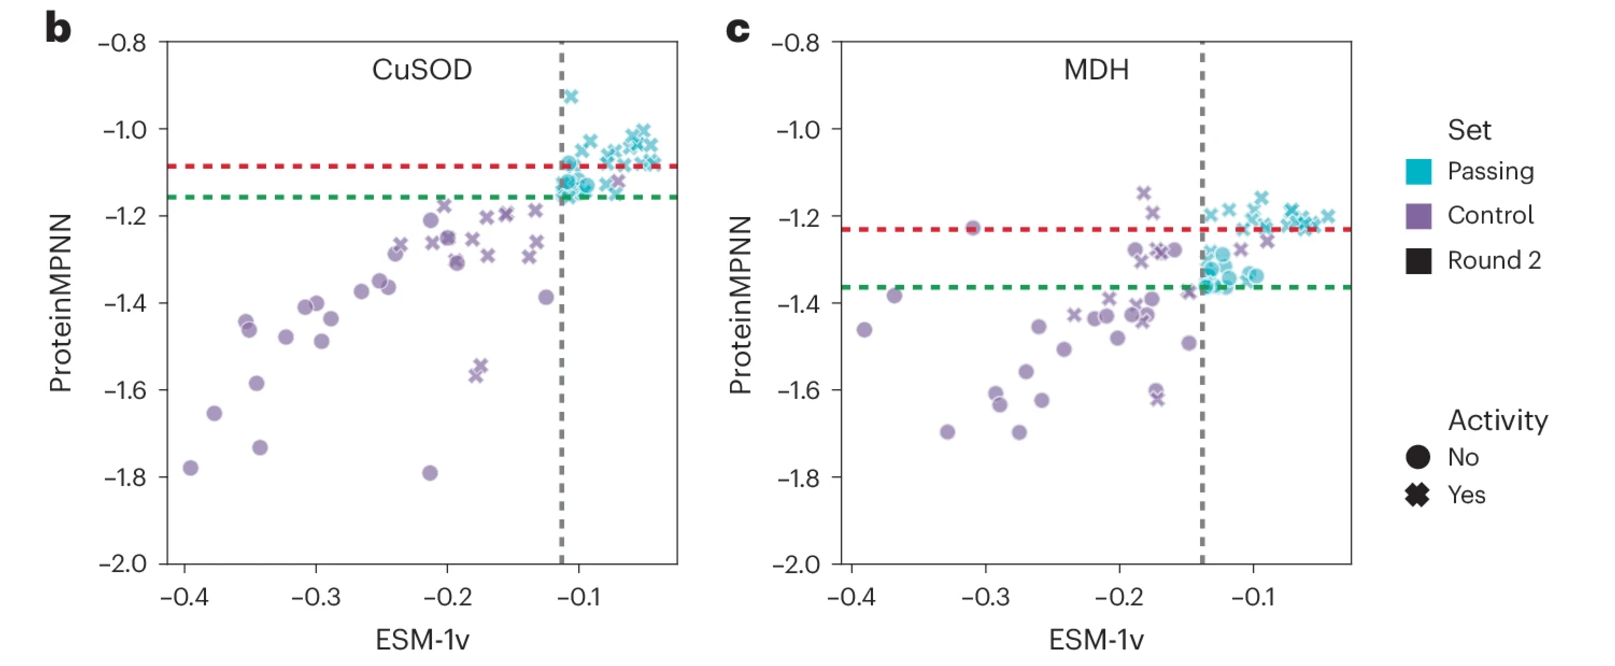  
  
ESM-1v and ProteinMPNN scores for CuSOD (b) and MDH (c) passed (cyan) and control (purple) sequences. The vertical dashed grey line represents the top 10 percentile cutoff of the ESM-1v score calculated for the test sequences. The horizontal dashed line is the ProteinMPNN score for the 40th ranked sequence among the 200 selected sequences. It can be seen that the higher the scores (especially ProteinMPNN), the greater the probability that the enzyme sequence is active.  
(Johnson, S.R., Fu, X., Viknander, S. et al. Computational scoring and experimental evaluation of enzymes generated by neural networks. Nat Biotechnol (2024). https://doi.org/10.1038/s41587-024-02214-2)

##### Question 11 Please evaluate the sequence you generated previously based on the sequence metrics (optional) and structure metrics (optional), and analyze the results to make a scatter plot (the title of the horizontal axis and the title of the vertical axis in the figure are set to the metrics you selected)
________________________________________________________________________________________

In [ ]:
#Type your code